In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import seaborn as sns

In [3]:
import cmath as z

In [4]:
import scipy as sp

In [5]:
%matplotlib inline

### Parameters

In [276]:
intDataCount = 1000
noiseStdProcess = 0.1
noiseStdObs =0.1
r=0.9
polar=0
compl=1

### Define the dynamics of the example linear ystem: diag(lam_true)

In [277]:
lam_true = [r*np.exp(complex(0,1)*np.pi/180*(90)), r*np.exp(complex(0,1)*np.pi/180*(-90))]

### Generate data for noiseless dynamics of exmaple linear system

In [278]:
# generate data for 2 dimensional dynamics on complex plane
def generateData2D(intDataCount,eigs,noiseStd):
    # intDataCount is number of data points to genereate
    # eigs : the true eigenvalues of the linear dynamics system
    # noiseStd : std of process noise to add
    # returns 

        # Y : 2 x 1000 array : complex valued co-ordinates
    
    Y = np.zeros((len(eigs),intDataCount), dtype=np.complex64) # 2x 1000
    Y[:,:1]=np.ones([len(eigs),1]) # zeroth column

    for index in range(1,intDataCount):
        Y[:,index:(index+1)]=np.matmul(sp.diag(eigs),Y[:,(index-1):index]) + np.random.randn(2,1)*noiseStd
    
    return Y
    
# convert to polar and stack into matrix
def convertPolar(Y):
    # Y : np.array : 2 x intDataCount
    # ret : array: polar co-ordinates radius and phase of shape 4 x 1000
    ret = []
    for i in range(0,2):
        r=[abs(pt) for pt in np.nditer(Y[:])]
        theta = [z.phase(pt) for pt in np.nditer(Y[:])]
        ret.append(r)
        ret.append(theta)
    return np.array(ret)

In [279]:
Y_noiseless = generateData2D(intDataCount,lam_true,0)

### Generate noisey data

In [280]:
Y = generateData2D(intDataCount,lam_true,noiseStdProcess)

### Convert to polar co-ords for plotting

In [281]:
convertPolar(Y_noiseless[0]).shape

(4, 1000)

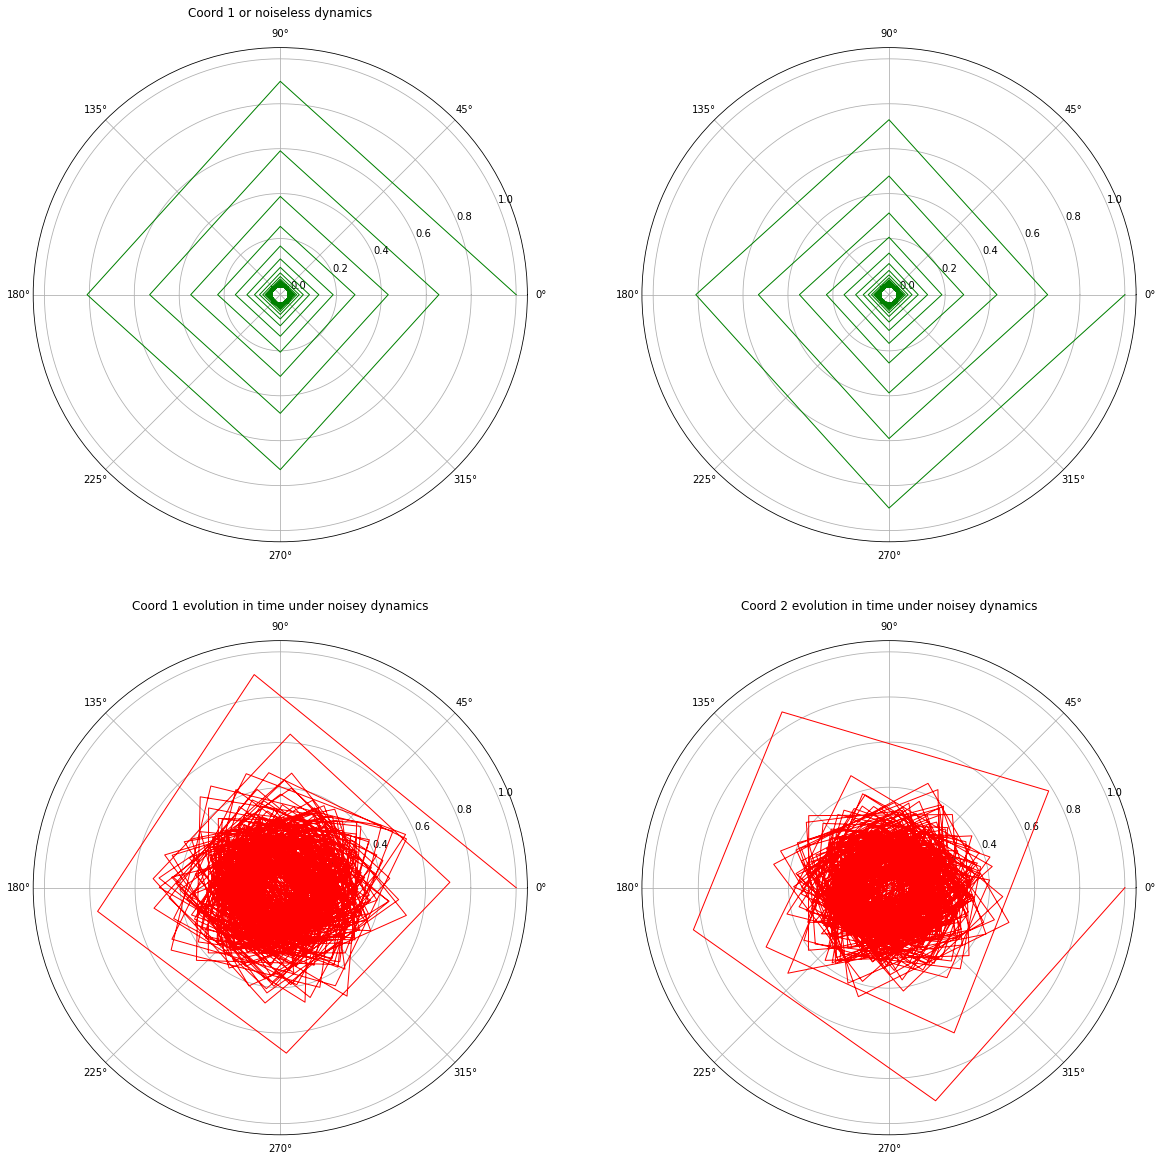

In [282]:
fig = plt.figure(figsize=(20,20))
ax=fig.add_subplot(221,polar=True)
ax2=fig.add_subplot(223,polar=True)
ax3=fig.add_subplot(224,polar=True)
ax4=fig.add_subplot(222,polar=True)

ax.set_title("Coord 1 or noiseless dynamics")
ax2.set_title("Coord 1 evolution in time under noisey dynamics")
ax3.set_title("Coord 2 evolution in time under noisey dynamics")

line,=ax.plot(convertPolar(Y_noiseless[0])[1],convertPolar(Y_noiseless[0])[0], color='green',lw=1)
line2,=ax2.plot(convertPolar(Y[0])[1],convertPolar(Y[0])[0],lw=1,color='red')
line3,=ax3.plot(convertPolar(Y[1])[1],convertPolar(Y[1])[0],lw=1,color='red')
line4,=ax4.plot(convertPolar(Y_noiseless[1])[1],convertPolar(Y_noiseless[1])[0],lw=1,color='green')


### Reduced (extact) DMD (i.e. extension via observation functions)

In [183]:
# performs a reduced rank SVD on the passed in matrix X=USV^h
def reducedDMD(X,r):
    # X : data matrix with data per column
    # r : desired rank
    U_r, S_r, V_r = sp.linalg.svd(X)
    U_r = U_r[:,0:r]
    S_r=S_r[0:r]
    V_r=V_r[0:r,:]
    return U_r,S_r,V_r

In [217]:
# ordinary exact DMD (no augmentation via observation functions)
def ordDMD(Y0,Y1,r):
    # Inputs:
    #   Y0,Y1 : np.arrays : data snapshots for t=0 and then time shifted
    # Returns:
    #   lam : rxr np.array : eigenvalues
    #   v_right :   : normalised right eigenvector
    #   w :  : modes of the dynamics
    
    ## Exact DMD
    
    # step 1 : perform SVD with reduced rank r
    U_r,S_r,Vh_r = reducedDMD(Y0,r)
    #step 2: projection onto POD
    M = Y1@Vh_r.conj().T@ np.diag([1./i for i in S_r])
    A_tilde = U_r.conj().T@M
    #step 3 eigen decomp of a_tilde 
    lam,v_right = np.linalg.eig(A_tilde)
    #step 4: calculate the modes
    w=M@v_right@ np.diag(1./lam)
    
    return np.diag(lam),v_right,w
    

### Add observation noise to the data that already has process noise present

In [283]:
obs_noise = np.random.randn(intDataCount)*noiseStdObs

In [284]:
Y=Y+obs_noise # add observation noise, same to each co-ordinate

In [285]:
## Do exact DMD 
rank= np.linalg.matrix_rank(Y)
lam,v,w =ordDMD(Y[:,0:(intDataCount-1)],Y[:,1:intDataCount],rank)

In [286]:
lam

array([[-0.00566990+0.76750394j,  0.00000000+0.j        ],
       [ 0.00000000+0.j        ,  0.01539317-0.73854896j]])